In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load data
df = pd.read_csv('../../Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [18]:
df = df.drop('CustomerID', axis=1)
df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})
X = df.iloc[:, [1, 2, 3]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
class DBSCANScratch:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels = np.zeros(n_samples, dtype=int)
        cluster_id = 0
        for i in range(n_samples):
            if self.labels[i] != 0:
                continue
            neighbors = self._region_query(X, i)
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1 
            else:
                cluster_id += 1
                self._expand_cluster(X, i, neighbors, cluster_id)
        self.labels[self.labels > 0] -= 1
        return self.labels

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id):
        self.labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if self.labels[neighbor_idx] == -1:
                self.labels[neighbor_idx] = cluster_id
            elif self.labels[neighbor_idx] == 0:
                self.labels[neighbor_idx] = cluster_id
                new_neighbors = self._region_query(X, neighbor_idx)
                if len(new_neighbors) >= self.min_samples:
                    neighbors.extend(new_neighbors)
            i += 1

    def _region_query(self, X, point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return list(np.where(distances <= self.eps)[0])

In [20]:
eps = 0.4
min_samples = 5
dbscan = DBSCANScratch(eps=eps, min_samples=min_samples)
labels = dbscan.fit(X_scaled)
if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled):
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
else:
    print("Clustering failed to find valid structure (either 1 cluster or all noise)")

Silhouette Score: 0.0760
Davies-Bouldin Score: 1.5758


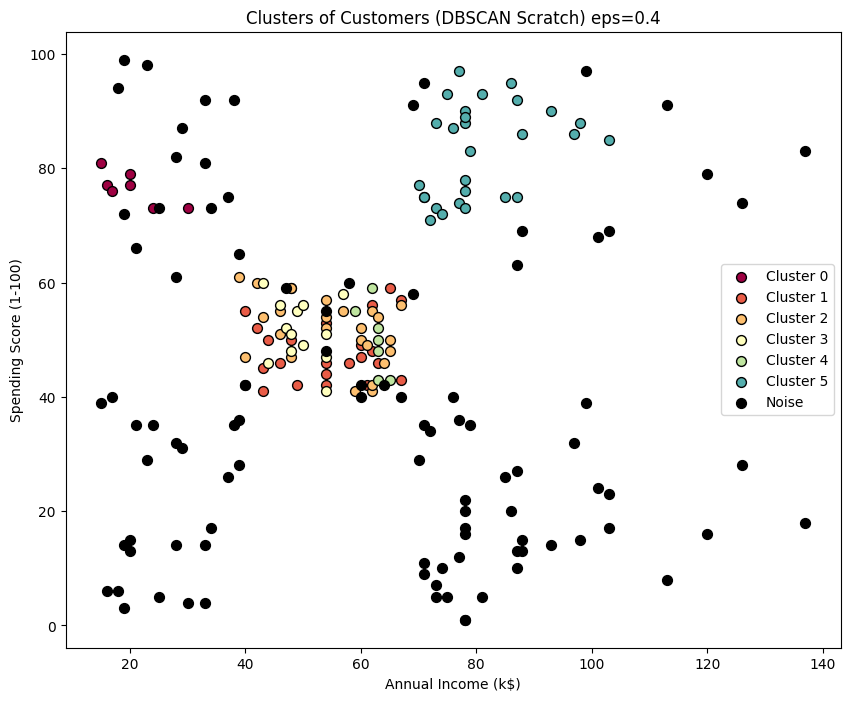

In [21]:
# Visualization
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
        label = 'Noise'
    else:
        label = f'Cluster {k}'
    plt.scatter(X[labels == k, 1], X[labels == k, 2], s=50, c=[col], label=label, edgecolor='k')
plt.title(f'Clusters of Customers (DBSCAN Scratch) eps={eps}')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()